In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import queue
import os, sys, time, json, random, string
import numpy as np
import socket
import datetime as dt
import warnings
%matplotlib inline
random.seed(101)

In [ ]:
##Maze and items and other global parametersaaaaaaaaaaaaaaaaa

maze1 = np.asarray([
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0],
    [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],])

ITEMS_LOC = [(6,6),(0,8),(0,0),[8,0]]
ITEMS = ['la lavende', 'les noix de coco','les pommes',  'inventory']
START_LOC = [8, 0]
EMOTIONS_LIST = ['F', 'E', 'EN']
N_EPOCH = 1000
HINTS = [0,1]
ACTIONS_DICT = {
    0: 'do nothing',
    0: 'left',
    1: 'up',
    2: 'right',
    3: 'down'
}
GAMMA = 0.95
MAX_MEMORY = 1000

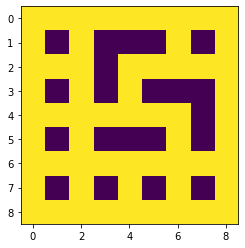

In [ ]:
plt.imshow(maze1)

In [ ]:
class Environment:
    def __init__(self, maze, items_loc, human, hint = 0):
        self._maze = np.array(maze)
        self.human = human
        self.human_loc = START_LOC
        self._targets = target_list
        self.free_cells = self.get_free_cells()
        self.blocked_cells = self.get_blocked_cells()
        self.hint_on_display = 0
        self.reset(human, hint)
        
    def reset(self, human,  hint= 0):
        self.human.reset()
        self.human_loc = START_LOC
        self.hint = hint
        self.hint_on_display = 0 #False
        self.time = 0
        self.maze = np.copy(self._maze)
        self.targets = set(self._targets)
        row,col = self.human_loc
        self.maze[row, col] = human_mark
        self.state = (self.human_loc, self.human.emotions, self.hint_on_display)
        self.total_reward = 0 #Total return of episode
        self.time_since_last_hint = 0.0001 #To avoid divide by zero
        self.base = np.sqrt(self.maze.size)
        self.min_reward =  - self.maze.size/len(self._targets)
        self.reward = {
            'targets'           :  1.0/len(self._targets),
            'hint_penalty'      : -len(self._targets) /self.base,
            'time_penalty'      : -1/self.maze.size,
            'hint_time_penalty' : -1/self.time_since_last_hint
        }
        
        nrows, ncols = self.maze.shape
        self.visited = dict(((r,c),0) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0)
    
    def update_action(self, hint):
        #Update human movement, update state and reward
        #print(hint, action)
        if(hint == 0):
            self.time_since_last_hint += 1      
        else:
            self.time_since_last_hint = 0
        
        action = self.human.move()
        self.update_state(action)
        reward = self.get_reward(hint)
        self.total_reward += reward
        status = self.game_status()
        env_state = self.observe()
        return env_state, reward, status
    
    def update_state(self, action):
        nrows, ncols = self.maze.shape
        self.human_loc, human.emotions, self.hint_on_display = self.state
        row, col = self.human_loc
        
        if self.maze[self.human_loc] > 0.0:
            self.visited[human.loc] += 1
        if human in self.targets:
            self.targets.remove(self.human_loc)
            
        if(self.hint == 1 or self.time_since_last_hint <= 5):
            self.hint_on_display = 1 #True
            
        #Update movement
        #Each step is 2 squares in VR Environment
        if action == 1:
            col -= 2
        elif action == 2:
            row -= 2
        elif action == 3:
            col += 2
        elif action == 3:
            row += 2
            
        self.human_loc = (row, col)
        self.state = (self.human_loc, self.human.emotions, self.hint_on_display)
    
    def observe(self):
        canvas = self.draw_env()
        env_state = canvas.reshape((1, -1))
        return env_state
    
    def draw_env(self):
        canvas = np.copy(self._maze)
        # draw the targets
        for r,c in self.targets:
            canvas[r,c] = target_mark
        # draw the human
        canvas[self.human_loc] = human_mark
        return canvas
    
    def get_reward(self, hint = 0):
        reward = 0
        
        if (self.hint_on_display == 1):
            return self.min_reward
        
        #Get reward based on past frustration value
        f = self.human.df_Emotions.loc['F']
        y = f[len(f) - self.base : len(f)]
        y.reverse()
        for ix, item in enumerate(y):
            reward = reward + item/((ix+1)*self.base)
        
        #Get reward based on change in frustration values
        for i in range(len(y)-1):
            reward = reward +  (y[i]- y[i+1])/(i+1)
        
        #If hint is given
        if hint == 1:
            reward = reward + self.reward['hint_penalty'] + self.reward['hint_time_penalty']
            
        #Reward based on targets collected and time spent
        if len(self.targets) == 0:
            reward =  reward + 1.0 + self.reward['targets']
        elif self.human_loc in self.targets:
            reward =  reward + self.reward['targets']
        else:
            reward =  reward + self.reward['time_penalty'] 
            
        return reward
        
        
    #Returns dictionary of cells with count of times visited
    def get_visited_cells(self):
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        visited = dict(((r,c),0) 
             for r in range(nrows) 
             for c in range(ncols) if self._maze[r,c] == 1.0)
        return visited
  
    #Returns numpy array of cells of maze in which movement is not allowed (walls)
    def get_blocked_cells(self):
        nrows, ncols = self._maze.shape
        blocked_cells =[[r,c] for r in range(nrows) for c in range(ncols) if maze1[r,c] == 0.0]
        return np.asarray(blocked_cells)
    
    #Returns the numpy array of cells in which free movement is allowed
    def get_free_cells(self):
        nrows, ncols = self._maze.shape
        free_cells = [[r,c] for r in range(nrows) for c in range(ncols) if maze1[r,c] == 1.0]
        return np.asarray(free_cells)
    
    #Returns valid actions from a certain location
    def valid_actions(self, cell = None):
        if cell is None:
            row, col = self.human_loc
        else:
            row, col = cell
        nrows, ncols = self.maze.shape
        actions = [0, 1, 2, 3, 4]
        
        if row == 0:
            actions.remove(2)
        elif row == nrows-1:
            actions.remove(4)
            
        if col == 0:
            actions.remove(1)
        elif col == ncols-1:
            actions.remove(3)
        
        if row > 0 and self.maze[row-1, col] == 0:
            actions.remove(2)
        if row < nrows-1 and self.maze[row+1, col] == 0:
            actions.remove(4)
        if col>0 and self.maze[row, col-1] == 0:
            actions.remove(1)
        if col<ncols-1 and self.maze[row, col+1] ==0:
            actions.remove(3) 
            
        return actions
    
    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        human.loc, human.emotions, mode = self.state
        if len(self.targets) == 0 :
            return 'win'
        return 'ongoing'
    


## Human Class
**Used to simulate the actions of human and generate corresponding EEG signals.** <br>
**Used to fetch emotions from EEG Headset in case of actual experiments.**

In [ ]:
class Human:
    def __init__(self, maze, n = 4, curr_emotion = [0, 0, 0, 0, 0]):
        self.emotions = curr_emotion
        self.df_Emotions = pd.DataFrame(columns = EMOTIONS_LIST)
        self.maze = maze
        self.n_items = n
        
    def reset(self, emotions = [0, 0, 0, 0, 0]):
        self.emotions = emotions
        self.loc = START_LOC
        self.items_left = self.n_items
    
    #Valid action from human perspective
    #Returns valid actions from a certain location
    def valid_actions(self):
        if cell is None:
            row, col = self.loc
        else:
            row, col = cell
        nrows, ncols = self.maze.shape
        actions = [0, 1, 2, 3, 4]
        
        if row == 0:
            actions.remove(2)
        elif row == nrows-1:
            actions.remove(4)
            
        if col == 0:
            actions.remove(1)
        elif col == ncols-1:
            actions.remove(3)
        
        if row > 0 and self.maze[row-1, col] == 0:
            actions.remove(2)
        if row < nrows-1 and self.maze[row+1, col] == 0:
            actions.remove(4)
        if col>0 and self.maze[row, col-1] == 0:
            actions.remove(1)
        if col<ncols-1 and self.maze[row, col+1] ==0:
            actions.remove(3) 
            
        return actions
    
    
    def move(self, hint = 0):
        if hint == 0:
            #Random walk
            move = random.choice(self.valid_actions)
        else:
            valid_moves = self.valid_actions()
            #Estimate direction to move based on hint
            x = np.array(self._curr_loc) - np.array(target_loc)
            y = []
            if (x[0]>1 ):
                y.append(2)
            if (x[0]<-1):
                y.append(4)
            if (x[1]>1):
                y.append(1)
            if (x[1]<-1):
                y.append(3)
            
            possible_move = list(set(actions).intersection(set(y)))
            
            if( len(possible_move) == 0):
                move = random.choice(valid_moves)
            else:
                move = random.choice(possible_move)
                
        #Update location
        row, col = self.loc
        if action == 1:
            col -= 2
        elif action == 2:
            row -= 2
        elif action == 3:
            col += 2
        elif action == 3:
            row += 2
        self.loc = (row, col)
        #
        if np.array_equal(self.loc, ITEMS_LOC(self.items_left)):
            self.items_left -= 1
        
        return move
    
    def simulate_emotions(self):
    #Simulate
        self.emotions = np.array(random.sample(range(0,10), 3)) * 0.1
        self.df_Emotion = self.df_Emotion.append(pd.Series(df_row, index = df_Emotion.columns), ignore_index = True)

    def fetch_emotions():
    #Get emotions from EEG when connected
        self.emotions = np.array(random.sample(range(0,10), 3)) * 0.1
        self.df_Emotion = self.df_Emotion.append(pd.Series(df_row, index = df_Emotion.columns), ignore_index = True)
    


## Q-Learning Experience Replay Class

In [ ]:
class Experience(object):
    def __init__(self, model, max_memory=MAX_MEMORY, discount=GAMMA):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, env_state):
        return self.model.predict(env_state)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # env_state 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        labels = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            env_state, action, reward, next_env_state, game_over = self.memory[j]
            inputs[i] = env_state
            labels[i] = self.predict(env_state)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(next_env_state))
            if game_over:
                labels[i, action] = reward
            else:
                labels[i, action] = reward + self.discount * Q_sa
        return inputs, labels

In [ ]:
class Qtraining():
    def __init__(self, model, env, human, n = N_EPOCH, start = START_LOC):
        self.model = model #NN model
        self.env = env     #Environment
        self.human = human
        self.n_epoch = n
        self.max_memory = 4* self.env.maze.size
        self.data_size = 0.75* self.env.maze.size
        self.start_cell = start
        self.init_hint = 0
        self.win_count = 0
        self.hint_list = []
        self.action_list = []
        self.human_path = []
        self.item_collected = 0


        #Initialize experience replay 
        self.experience = Experience(self.model, max_memory= self.max_memory)
        
    def train(self):
        start_time = datetime.datetime.now()
        self.seconds = 0
        self.win_count = 0
        self.curr_epoch = 0
        for epoch in range(self.n_epoch):
            self.epoch = epoch
            self.curr_epoch += 1
            self.loss = 0.0
            human = self.start_cell
            #print(all_targets)
            self.env.reset(self.start_cell, self.init_hint)
            game_over = False
            self.env_state = self.env.observe()
            self.n_episodes = 0
            self.hint_list = []
            self.action_list = []
            #self.human_loc.append(human)
            while not game_over:
                game_over = self.play()

            dt = datetime.datetime.now() - start_time
            self.seconds = dt.total_seconds()
            t = format_time(self.seconds)
            #fmt = "Epoch: {:3d}/{:d} | Loss: {:.4f} | Episodes: {:4d} | Wins: {:2d} | Targets: {:d} | e: {:.3f} | time: {}"
            #print(fmt.format(epoch, self.n_epoch-1, self.loss, self.n_episodes, self.win_count, len(self.env.targets), self.epsilon(), t))
            #print(str(env.total_reward) + str(env.targets) + str(env.state))
            #print('Hints :' +str(self.hint_list))
            #print('Actions :' +str(self.action_list))
            #print('Actions :' +str(self.human_loc))


            self.item_collected += (len(self.env._targets) - len(self.env.targets)) / 3

            #if epoch > 2:
            #    if self.completion_check():
            #        print("Completed training at epoch: %d" %(epoch, ))
            #        break   

            if (epoch+1)%2 == 0:
                fmt = "Epoch: {:3d}/{:d} | Loss: {:.4f} | Episodes: {:4d} | Wins: {:2d} | Targets: {:d} | e: {:.3f} | time: {}"
                print(fmt.format(epoch, self.n_epoch-1, self.loss, self.n_episodes, self.win_count, len(self.env.targets), self.epsilon(), t))
                print(str(env.total_reward) + str(env.targets) + str(env.state))
                print('Hints :' +str(self.hint_list))
                print('Actions :' +str(self.action_list))


    def play(self):
        hint = self.get_hint()
        action = self.human.move(hint)
        self.action_list.append(action)
        prev_env_state = self.env_state
        self.env_state, reward, game_status = self.env.update_action(hint, action)
        #self.human_loc.append(self.env.human)
        #print(game_status)
        #print(env.total_reward)
        if game_status == 'win':
            self.win_count += 1
            game_over = True
        elif game_status == 'lose':
            game_over = True
        else:
            game_over = False

        #episode = [prev_env_sate, action, hint, reward, self.env_state, game_over]
        episode = [prev_env_state, hint, reward, self.env_state, game_over]

        self.experience.remember(episode)
        self.n_episodes += 1

        # Train model
        inputs, targets = self.experience.get_data(data_size=self.data_size)
        epochs = int(self.env.base)
        h = self.model.fit(
            inputs,
            targets,
            epochs = epochs,
            batch_size=16,
            verbose=0,
        )
        self.loss = self.model.evaluate(inputs, targets, verbose=0)
        return game_over
        
    def run_game(self, hint = 0):
        self.env.reset(self.human, hint)
        self.hint_list = []
        self.action_list = []
        env_state = self.env.observe()
        while True:
            #get next hint
            q = self.model.predict(env_state)
            hint = np.argmax(q[0])
            action = self.human.move(hint)
            self.hint_list.append(hint)
            self.action_list.append(action)
            prev_env_state = env_state
            #Apply hint and action
            env_state, reward, game_status = self.env.update_action(hint, action)
            print('Hints :' +str(self.hint_list))
            print('Actions :' +str(self.action_list))
            if game_status == 'win':
                return True
            elif game_status == 'lose':
                return False

    def get_hint(self):
        #Get next hint
        valid_hints = HINTS
        if np.random.rand()< self.epsilon():
            hint = random.choice(valid_hints)
        else:
            q = self.experience.predict(self.env_state)
            hint = np.argmax(q)
        self.hint_list.append(hint)
        return hint
        
    def epsilon(self):
        #n = self.win_count
        n = self.curr_epoch
        high = 0.25
        low = 0.05
        e = low + (high - low) /  (1 + 0.1 * np.log(n) )
        return e
        
    def completion_check(self):
        if not self.run_game(self.start_cell, hint = 0):
            return False
        return True
    
    def save(self, name=""):
        # Save trained model weights and architecture, this will be used by the visualization code
        if not name:
            name = self.name
        h5file = 'model_%s.h5' % (name,)
        json_file = 'model_%s.json' % (name,)
        self.model.save_weights(h5file, overwrite=True)
        with open(json_file, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
        t = format_time(self.seconds)
        print('files: %s, %s' % (h5file, json_file))
        print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (self.epoch, self.max_memory, self.data_size, t))

In [ ]:
def build_model(env):
    loss =  'mse'
    a = opt.get('alpha', 0.24)
    model = Sequential()
    esize = env.maze.size
    model.add(Dense(esize, input_shape = (esize,)))
    model.add(LeakyReLU(alpha = a))
    model.add(Dense(esize))
    model.add(LeakyReLU(alpha = a))
    model.add(Dense(2))
    model.compile(optimizer = 'adam', loss = 'mse')
    return model

In [ ]:
env = Maze(maze, ITEMS_LOC)
human = human

In [ ]:
model = build_model(env)

qt = Qtraining(
    model,
    env,
    n_epoch = 1000,
    max_memory = 1000,
    data_size = 256,
    name = 'model_1'
)

qt.train()